# Big project

## Submission

Submit solutions to https://forms.office.com/e/WexY7YraJb.

1.   Upload code in .ipynb file
2.   Upload a csv containing three columns: 
*    "ID": the ID of the instance (1, 2, 3, ...)
*    "OBJ": the objective function value obtained
*    "TIME": the execution time in seconds.

## Evaluation

1.   Gap w.r.t. optimal solutions
2.   Runtimes. Must be under 10 minutes for every instance. Execution times will be re-examined on a random basis.

## Deadline

12/01/2022 23:59 CET

## Other

*   4 lab points just if you deliver something that works
*   10 points based on the quality of method
*   NO pre-coded libraries, 
*   NO genetic algorithms 
*   NO neural networks
*   groups of max 3 students




## Biogas plants location

An association of $n$ farmers wants to open $p$ plants to produce energy from biogas. 
Each plant will be opened at a farm of a member of the association and will be powered with corn chopping purchased from the farm itself or from other neighboring farms.

Each farm $i$ can provide at most $c_i$ tons of corn chopping, with a percentage of dry matter $a_i$. As you may know, dry matter is the key component of corn chopping used for biogas production. In order to maintain the quality of produced energy, each plant must burn a mixture of corn chopping with a percentage of dry matter between $k_{min}$ and $k_{max}$. 

At most one plant can be located in each farm, and every farm can sell its corn chopping to one and only one plant.

Each farm $i$ is located at coordinates $x_i$ and $y_i$, representing respectively its latitude and longitude, and the cost of moving corn chopping from a farm $i$ to a farm $j$ is proportional to the euclidean distance between the two farms (it does not depend on the actual quantity moved, since the trucks used for this transportations are sufficiently big). 

Under such conditions, every plant produces $Q$ kWh of energy per ton of corn chopping burned. The energy produced by each plant will be fed into the national electricity system, at a unitary price of $b$ (€/kWh). Moreover, due to state regulations, each plant must not produce more than $M$ kWh of energy.

You must locate $p$ plants among the available farms and assign the farms that will supply each plant, with the goal of maximizing the total revenues of the association.

### Sets
*   $I$ = set of farms

### Parameters
*   $n$ = number of farms   
*   $p$ = number of plants to locate
*   $b$ = revenue per unit of energy (€/kWh)
*   $M$ = max energy production (kWh)
*   $Q$ = energy produced by a ton of corn chopping (kWh/t)
*   $k_{min} (k_{max})$ = min (max) percentage of dry matter for fermentation
*   $a_i$ = percentage of dry matter in chopping from farm $i \in I$
*   $c_i$ = tons of corn chopping available for each $i \in I$ (t)
*   $x_i, y_i$ = coordinates of farm $i \in I$

### Download instance

In [40]:
instance_id = 3;
baseUrl = "https://raw.githubusercontent.com/Daddeee/FOR_Labs_22-23/master/big-project";
istanceUrl = f'{baseUrl}/instances/instance_{instance_id}.json';
resultUrl = f'{baseUrl}/results/instance_{instance_id}.txt';
dataPath = "./data/"

!rm -rf {dataPath}
!wget {istanceUrl} -P {dataPath}
!wget {resultUrl} -P {dataPath}

--2022-12-22 20:19:53--  https://raw.githubusercontent.com/Daddeee/FOR_Labs_22-23/master/big-project/instances/instance_3.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 2606:50c0:8000::154, 2606:50c0:8001::154, 2606:50c0:8002::154, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|2606:50c0:8000::154|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1981 (1.9K) [text/plain]
Saving to: './data/instance_3.json'

instance_3.json     100%[===================>]   1.93K  --.-KB/s    in 0s      

2022-12-22 20:19:53 (12.0 MB/s) - './data/instance_3.json' saved [1981/1981]

--2022-12-22 20:19:54--  https://raw.githubusercontent.com/Daddeee/FOR_Labs_22-23/master/big-project/results/instance_3.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 2606:50c0:8000::154, 2606:50c0:8001::154, 2606:50c0:8002::154, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|2606:50c0:8000::154|:443... co

### Import libraries

In [41]:
import numpy as np
import math
import mip
import json
import networkx as nx
import matplotlib.pyplot as plt
import time

### Compute distance

In [42]:
def fast_distance_matrix(x):
    xy = x @ x.T
    x2 = xy.diagonal()[:,np.newaxis]
    return np.abs(x2 + x2.T - 2. * xy)**0.5

### Load instances

In [43]:
# Reads a .json instance and returns it in a dictionary
def load_instance(filename):
  with open(f'./data/{filename}', 'r') as f:
    data = json.load(f)
  return data

# Reads a .txt result and returns it
def load_result(filename):
  with open(f'./data/{filename}', 'r') as f:
      result = f.read()
  return float(result)

inst = load_instance(f'instance_{instance_id}.json')
inst_result = load_result(f'instance_{instance_id}.txt') if instance_id <= 4 else None;

### Model

In [44]:
class Model:
    def __init__(self, instance):
        self.M = instance["M"]
        self.Q = instance["Q"]
        self.a = np.array(instance["a"])
        self.b = instance["b"]
        self.c = instance["c"]
        self.kmax = instance["kmax"]
        self.kmin = instance["kmin"]
        self.I = range(instance["n"])
        self.p = instance["p"]
        self.points = instance["points"]
        self.distances = fast_distance_matrix(np.array(self.points))

        self.m = mip.Model();
        self.setupVariables(isILP=False)
        self.setupConstraint()
                
        self.m.objective = mip.maximize(mip.xsum([self.z[i][j] * self.Q * self.b - self.y[i][j] * self.distances[i][j] for j in self.I for i in self.I]))
    
    def setupVariables(self, isILP = False):
        self.x = [self.m.add_var(var_type = (mip.INTEGER if isILP else mip.CONTINUOUS), lb= 0, ub=1) for i in self.I]
        self.y = [[self.m.add_var(var_type = (mip.INTEGER if isILP else mip.CONTINUOUS), lb=0, ub=1) for j in self.I] for i in self.I]
        self.z = [[self.m.add_var(lb = 0) for j in self.I] for i in self.I]

        

    def setupConstraint(self):
        #build p plants
        self.m.add_constr(mip.xsum([self.x[i] for i in self.I]) == self.p)
        
        #each farm can be assigned to at most one farm
        for j in self.I:
            self.m.add_constr(mip.xsum([self.y[i][j] for i in self.I]) <= 1)

        for i in self.I:
            for j in self.I:
                self.m.add_constr(self.y[i][j] <= self.x[i])

        #each farm can at most give c_i corn choppings, linking constraint
        for i in self.I:
            for j in self.I:
                self.m.add_constr(self.z[i][j] <= self.c[j] * self.y[i][j])

        # dry mattern percentage
        for i in self.I:
            chorn_choppings_aquired = mip.xsum([self.z[i][j] for j in self.I])
            self.m.add_constr(mip.xsum([self.z[i][j] * self.a[j] for j in self.I]) <= self.kmax * chorn_choppings_aquired)
            self.m.add_constr(mip.xsum([self.z[i][j] * self.a[j] for j in self.I]) >= self.kmin * chorn_choppings_aquired)

        # state regulations
        for i in self.I:
            self.m.add_constr(mip.xsum([self.z[i][j] for j in self.I]) * self.Q <= self.M)

### Print result

In [45]:
def printVariableMatrix(var, label):
  print(f"\n{label}")
  for i in range(len(var)):
    print([f"{var[i][j].x:.5f}" for j in range(len(var[i]))])


def printVariableArray(var, label):
    print(f"\n{label}")
    print([f"{var[i].x:.5f}" for i in range(len(var))])


def printVarMatrixValue(var, i, j):
  print(f"{var[i][j].x:.5f}")


def printVariables(model, x = True, y = True, z = True):
  if x:
    printVariableArray(model.x, "X")
  if y:
    printVariableMatrix(model.y, "Y")
  if z:
    printVariableMatrix(model.y, "Z")
  

In [46]:
treshold = 1e-7

def printModelObjctiveResult(model:Model):
    obj = model.m.objective_value;
    gap = 100 * (obj - inst_result) / inst_result if inst_result != None else None;
    if gap != None:
        print(f"Obj Func: {obj:.5f}, Gap: {gap:.5f} %")
    else:
        print(f"Obj Func: {obj:.5f}, Gap: Non specified")



def print_model(model:Model, figsize, font_size, textual = False, weight = False):
    m = model.m
    x = model.x
    y = model.y
    z = model.z
    I = model.I
    c = model.c
    
    printModelObjctiveResult(model)

    if (textual):
        print("\n-----Farms-----")
        for i in I:
            if x[i].x > treshold:
                print(f"[--- x_{i} = {x[i].x:.3f} ---]")
                for j in I:
                    if y[i][j].x > treshold:
                        rank = model.Q * model.b * model.z[i][j].x - model.y[i][j].x * model.distances[i][j];
                        print(f"{j} -(y = {y[i][j].x:.3f} z = {z[i][j].x:.2f} c = {c[j]:.3f} rank = {rank:.5f})-> {i};")

        print("\n----- Arcs ------")
        for j in I:
            print(f"[--- x_{j} = {x[j].x:.3f} ---]")
            for i in I:
                if y[i][j].x > treshold:
                    rank = model.Q * model.b * model.z[i][j].x - model.y[i][j].x * model.distances[i][j];
                    print(f"{j} -(y = {y[i][j].x:.3f} z = {z[i][j].x:.2f} c = {c[j]:.3f} rank = {rank:.5f})-> {i};")

    #Visualize solution on graph
    pos_c = {i: (model.points[i][0], model.points[i][1]) for i in I}
    nodepos = {**pos_c}
    
    g = nx.DiGraph(directed = True)
    g.add_nodes_from([i for i in I])

    if (weight):
        w_edges = [(j, i, f'y = {y[i][j]:.2f}') for j in I for i in I if y[i][j].x > treshold] 
        g.add_weighted_edges_from(w_edges)
    else:
        edges = [(j, i) for j in I for i in I if y[i][j].x > treshold] 
        g.add_edges_from(edges)


    color = ['yellow' if x[i].x > treshold else 'cyan' for i in I]
    plt.figure(1, figsize=figsize)
    labels = nx.get_edge_attributes(g,'weight')
    nx.draw_networkx(g, font_size=font_size, pos=nodepos, node_color=color)
    nx.draw_networkx_edge_labels(g,pos=nodepos,edge_labels=labels)
    plt.show()    

## Solver

Obj Func: 2358134.41610, Gap: 0.04529 %


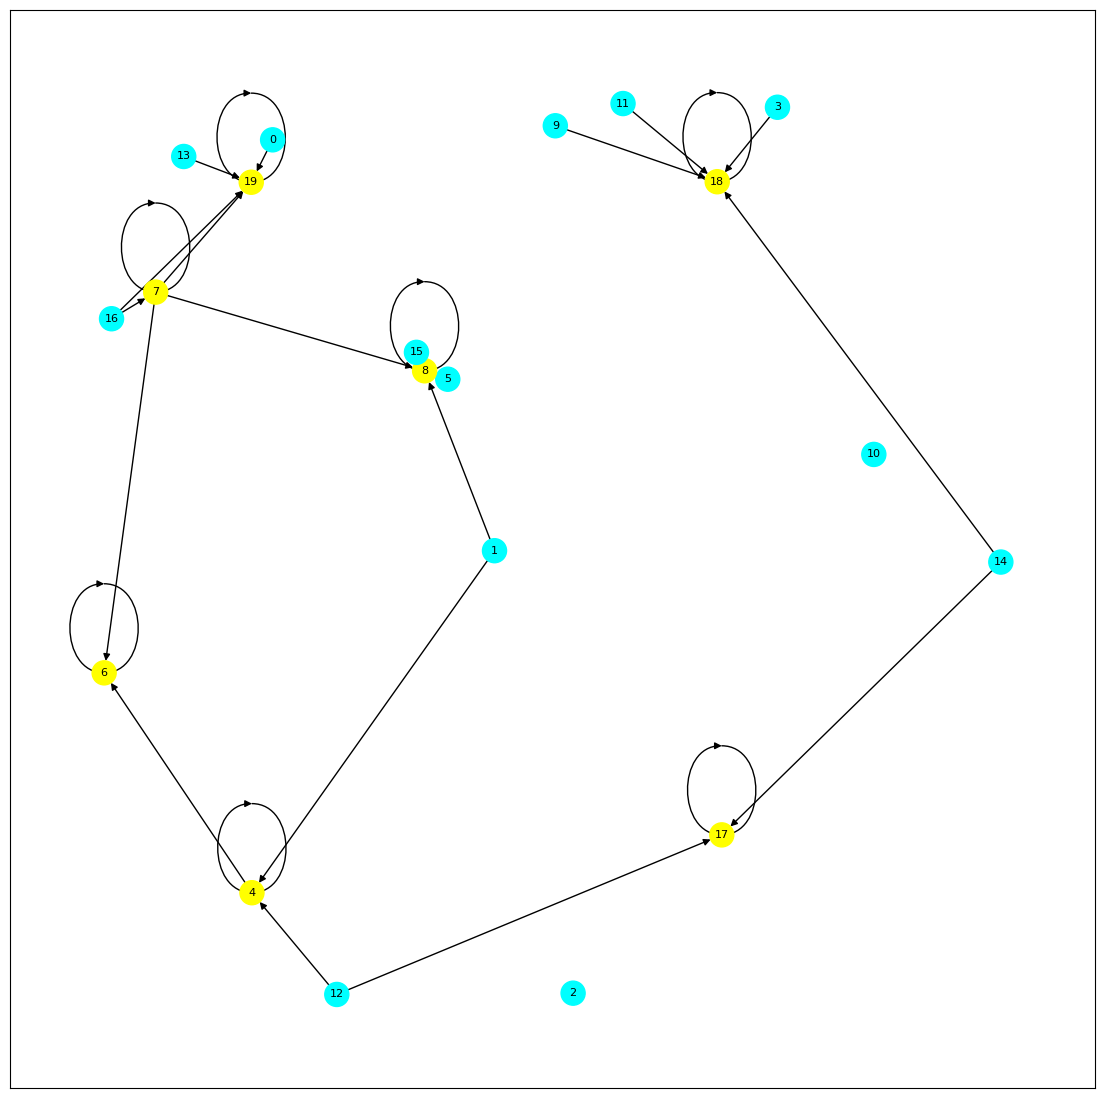

In [47]:
def solve(inst) -> Model:
    model = Model(inst)
    model.m.verbose = 0;
    model.m.optimize();
    return model;

model = solve(inst)
print_model(model, figsize=(14, 14), font_size=8)


In [48]:
# printVariables(model);

## LP Rounding Algorithm

------------------------- ITERATION 0 -------------------------------------
Obj Func: 2358134.41609, Gap: 0.04529 %
-------------------------     END 0.001s ----------------------------------------------------
------------------------- ITERATION 1 -------------------------------------
Relaxed y[19][16] = 1 from y[19][16] = 0.02838 z[19][16] = 53.35457 d[19][16] = 21.34376 x[19] = 1.00000 rank = 238834.24033
Obj Func: 2358116.42964, Gap: 0.04453 %
-------------------------     END 0.002s ----------------------------------------------------
------------------------- ITERATION 2 -------------------------------------
Relaxed y[19][7] = 1 from y[19][7] = 0.47300 z[19][7] = 660.77496 d[19][7] = 15.93710 x[19] = 1.00000 rank = 177474.09002
Obj Func: 2358089.72838, Gap: 0.04339 %
-------------------------     END 0.002s ----------------------------------------------------
------------------------- ITERATION 3 -------------------------------------
Relaxed y[19][19] = 1 from y[19][19] = 0.70728 

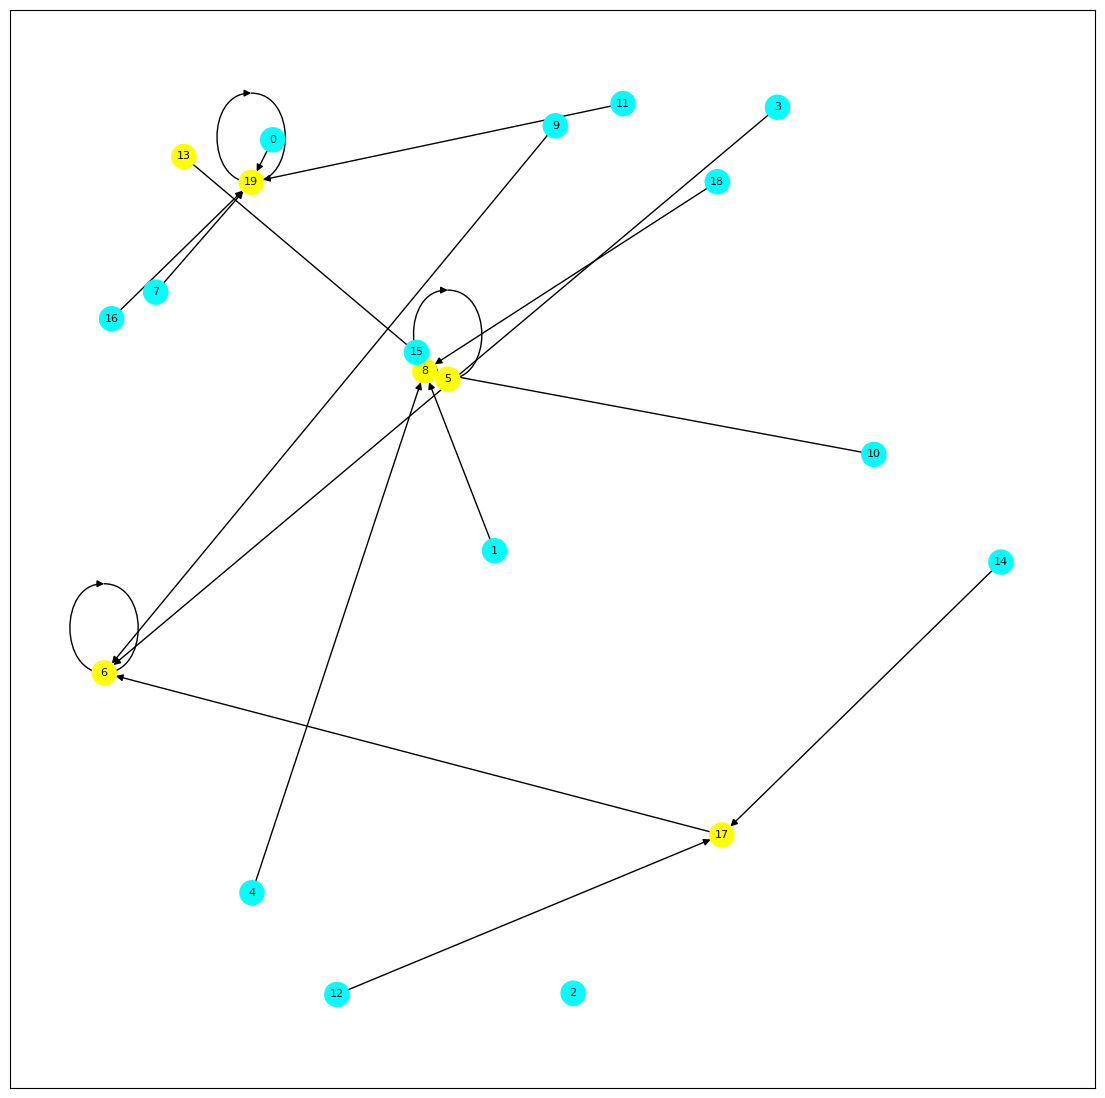

Task finished after: 0.23713


In [51]:
eps = 1e-3;
n_iterations = 0
start_time = time.time()
pair = None  # Initialize pair to None, leave the loops
delta = - math.inf;
while True:
    print(f'------------------------- ITERATION {n_iterations} -------------------------------------')
    if (pair != None):
        i, j = pair;
        relaxed_val = 1;
        model.m.add_constr(model.y[i][j] == relaxed_val)
        print(f"Relaxed y[{i}][{j}] = {relaxed_val} from y[{i}][{j}] = {model.y[i][j].x:.5f} z[{i}][{j}] = {model.z[i][j].x:.5f} d[{i}][{j}] = {model.distances[i][j]:.5f} x[{i}] = {model.x[i].x:.5f} rank = {model.x[i].x * (model.Q * model.b * model.c[j] - model.distances[i][j]):.5f}")
            

    start_optimization_time = time.time()
    model.m.optimize()
    printModelObjctiveResult(model)
    #print_model(model, figsize=(14, 14), font_size=8)
    print(f'-------------------------     END {time.time() - start_optimization_time:.3f}s ----------------------------------------------------')

    n_iterations += 1
    pair = None
    delta = -math.inf;
    for j in model.I:
        dict = {}
        for i in model.I:
            if abs(model.y[i][j].x) > eps and abs(model.y[i][j].x - 1) > eps:
                rank = model.x[i].x * (model.Q * model.b * model.c[j] - model.distances[i][j]);
                dict[i] = rank

        if (len(dict) >= 1):
            max_i = max(dict, key= lambda x: dict[x])
            curr_delta = dict[max_i];
            for k, v in dict.items():
                if (k != max_i):
                    curr_delta -= - v;
            if (curr_delta > delta):
                delta = curr_delta;
                pair = (max_i, j)

    if pair == None:
        break  # No violated inequality was found, leave the loop

print_model(model, figsize=(14, 14), font_size=8)
print(f'Task finished after: {time.time() - start_time:.5f}')

In [49]:
# eps = 1e-5
# def computeDelta(x, y, z, j):
#     delta = 0;
#     dict = {}
#     for i in range(len(y)):
#         if (abs(y[i][j]) > eps and abs(y[i][j] - 1) > eps):
#             dict[i] = (model.Q * model.b * model.c[j] - model.distances[i][j]) - (model.Q * model.b * z[i][j] - model.distances[i][j] * y[i][j])

#     if (len(dict) == 0):
#         return (0, None);
#     if (len(dict) == 1):
#         i = list(dict)[0];
#         return (dict[i], i); 
    
#     max_i = max(dict, key= lambda x: dict[x])
#     for i, v in dict.items():
#         if (i == max_i):
#             delta += dict[i]
#             y[i][j] = 1
#             z[i][j] = model.c[j]
#         else:
#             old_delta = (model.Q * model.b * z[i][j] - model.distances[i][j] * y[i][j]);

#             max_val = -math.inf;
#             for new_j in range(len(y)):
#                 if (new_j == j):
#                     continue;

#                 y_left = 1;
#                 for i_tmp in range(len(y)):
#                     y_left -= y[i_tmp][new_j];

#                 max_val = max(max_val, model.Q * model.b * model.c[j] * y_left - model.distances[i][j] * y_left)
                

#             delta = delta - (model.Q * model.b * z[i][j] - model.distances[i][j] * y[i][j]) + max_val;
#             y[i][j] = 0
#             z[i][j] = 0
        
#         for new_j in range(len(y)):
#             if (abs(y[i][new_j]) > eps):
#                 (new_delta, new_max) = computeDelta(x, y, z, new_j)
#                 delta += new_delta
    
#     return (delta, max_i);


# x = [model.x[i].x for i in model.I];
# y =[[model.y[i][j].x for j in model.I] for i in model.I]
# z =[[model.z[i][j].x for j in model.I] for i in model.I]


# res = computeDelta(x, y, z, 2)
# print(res)


In [50]:
# eps = 1e-3
# n_iterations = 0
# start_time = time.time()
# pair = None  # Initialize pair to None, leave the loops
# delta = - math.inf;
# while True:
#     print(f'------------------------- ITERATION {n_iterations} -------------------------------------')
#     increased_obj_value = model.m.objective_value + delta;
#     increment = 100 * ((increased_obj_value - model.m.objective_value) / abs(model.m.objective_value))
#     print(f"Delta = {delta:.5f} Increment: {increment:.5f}%")
#     if (pair != None):
#         i, j = pair;
#         relaxed_val = 1;
#         model.m.add_constr(model.y[i][j] == relaxed_val)
#         print(f"Relaxed y[{i}][{j}] = {relaxed_val} from y[{i}][{j}] = {model.y[i][j].x:.5f} z[{i}][{j}] = {model.z[i][j].x:.5f} d[{i}][{j}] = {model.distances[i][j]:.5f} x[{i}] = {model.x[i].x:.5f} rank = {model.x[i].x * (model.Q * model.b * model.c[j] - model.distances[i][j]):.5f}")
            

#     start_optimization_time = time.time()
#     model.m.optimize()
#     #printModelObjctiveResult(model)
#     print_model(model, figsize=(14, 14), font_size=8)
#     print(f'-------------------------     END {time.time() - start_optimization_time:.3f}s ----------------------------------------------------')

#     n_iterations += 1
#     pair = None
#     delta = -math.inf;
    
#     for j in model.I:
#         if (x[j] > eps): continue;
#         count = 0;
#         for i in model.I:
#             if abs(model.y[i][j].x) > eps and abs(model.y[i][j].x - 1) > eps:
#                 count += 1;

#         if (count >= 1):
#             x = [model.x[i].x for i in model.I];
#             y =[[model.y[i][j].x for j in model.I] for i in model.I]
#             z =[[model.z[i][j].x for j in model.I] for i in model.I]
#             (curr_delta, i) = computeDelta(x, y, z, j);
#             if (i != None and curr_delta > delta):
#                 delta = curr_delta;
#                 pair = (i, j);

            

#     if pair == None:
#         break  # No violated inequality was found, leave the loop

# print_model(model, figsize=(14, 14), font_size=8)
# print(f'Task finished after: {time.time() - start_time:.5f}')

In [52]:
# eps = 1e-5
# n_iterations = 0
# start_time = time.time()
# pair = None  # Initialize pair to None, leave the loops
# delta = - math.inf;
# while True:
#     print(f'------------------------- ITERATION {n_iterations} -------------------------------------')
#     increased_obj_value = model.m.objective_value + delta;
#     increment = 100 * ((increased_obj_value - model.m.objective_value) / abs(model.m.objective_value))
#     print(f"Delta = {delta:.5f} Increment: {increment:.5f}%")
#     if (pair != None):
#         i, j = pair;
#         relaxed_val = 0;
#         model.m.add_constr(model.y[i][j] == relaxed_val)
#         print(f"Relaxed y[{i}][{j}] = {relaxed_val} from y[{i}][{j}] = {model.y[i][j].x:.5f} z[{i}][{j}] = {model.z[i][j].x:.5f} d[{i}][{j}] = {model.distances[i][j]:.5f} x[{i}] = {model.x[i].x:.5f} rank = {model.x[i].x * (model.Q * model.b * model.c[j] - model.distances[i][j]):.5f}")
            

#     start_optimization_time = time.time()
#     model.m.optimize()
#     printModelObjctiveResult(model)
#     #print_model(model, figsize=(14, 14), font_size=8)
#     print(f'-------------------------     END {time.time() - start_optimization_time:.3f}s ----------------------------------------------------')

#     n_iterations += 1
#     pair = None
#     delta = -math.inf;
#     for j in model.I:
#         dict = {}
#         for i in model.I:
#             if abs(model.y[i][j].x) > eps and abs(model.y[i][j].x < 1) > eps:
#                 # rank = model.y[i][j].x;
#                 rank = model.x[i].x * (model.Q * model.b * model.c[j] - model.distances[i][j]);
#                 dict[i] = rank

#         if (len(dict) >= 2):
#             max_i = max(dict, key= lambda x: dict[x])
#             curr_delta = (1 - model.y[max_i][j].x) * (model.Q * model.b * model.c[j] - model.distances[max_i][j]);
#             for k, v in dict.items():
#                 if (k != max_i):
#                     curr_delta -= (model.y[k][j].x * (model.Q * model.b * model.c[j] - model.distances[k][j]));
#             if (curr_delta > delta):
#                 delta = curr_delta;
#                 pair = (max_i, j)

#     if pair == None:
#         break  # No violated inequality was found, leave the loop

# print_model(model, figsize=(14, 14), font_size=8)
# print(f'Task finished after: {time.time() - start_time:.5f}')
